# Imports

In [ ]:
import numpy as np
!pip install -q qiskit
from qiskit import QuantumCircuit,ClassicalRegister, QuantumRegister
from qiskit.quantum_info import Operator,Statevector
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler
from qiskit import transpile
from qiskit.providers.basic_provider import BasicProvider

## Functions

In [22]:
def getoracle(n,case):
    qc= QuantumCircuit(n+1)
    if case=="constant":
        if 1==np.random.randint(2):
            qc.x(n)
    else: 
        for i in range(n):
            qc.cx(i,n)
    qc=qc.to_gate()
    qc.name="phaseoracle"
    return qc

In [42]:
def DJA(n,case="random"):
    qc=QuantumCircuit(n+1,n)
    if case=="random":
        if 0==np.random.randint(2):
            case="constant"
        else: 
            case="balanced"
    for i in range(n):
        qc.h(i)
    qc.x(n)
    qc.h(n)
    qc.barrier()
    qc.append(getoracle(n,case),range(n+1))
    qc.barrier()
    for i in range(n):
        qc.h(i)
        qc.measure(i,i)
    return qc

# Example


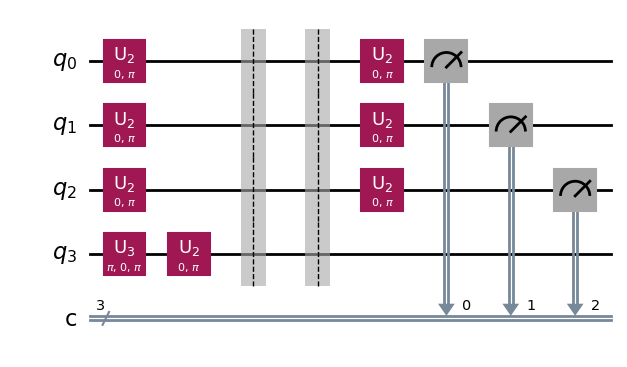

In [45]:
n=3
qc=DJA(3,'constant')
qc.decompose().draw('mpl')

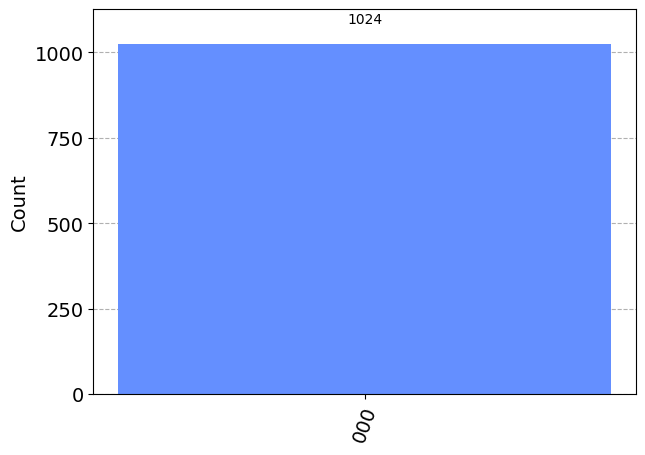

In [46]:
from qiskit.providers.basic_provider import BasicSimulator
backend = BasicSimulator()
result = backend.run(qc.decompose()).result()
plot_histogram(result.get_counts())

# Type 1

## Functions

In [41]:
def phaseoracleOperator(fn,num_qubits):
    values=[]
    for i in range(2**num_qubits):
        values.append((-1.)**(fn(i)))
    for value in values:
        if not (value==-1 or value==1):
            raise ValueError("Error fn value are not -1 and 1. Not boolean") 
    summation=sum(values)
    if not ((summation== 0)  or  (summation==-1*(2**num_qubits)) or  (summation== (2**num_qubits))):
        raise ValueError(f"function is not balanced or constant.Here is the sum of all values function outputs:{summation}")
    unitary= np.identity(2**num_qubits)
    for i in range(2**num_qubits):
        unitary[i,i]=values[i]
    return Operator(unitary)

In [42]:
def oracle(num_qubits,fn):
    qc=QuantumCircuit(num_qubits,name='oracle')
    qc.unitary(phaseoracleOperator(fn,num_qubits),range(num_qubits))
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst,list(range(num_qubits)))
    return qc

In [45]:
def DJA(num_qubits,fn):
    if num_qubits<=1:
        raise ValueError("num_qubits should be greater than 1")
    #QuantumRegisters
    qr=QuantumRegister(num_qubits,'x')
    qr1=QuantumRegister(1,'function')
    #ClassicalRegisters
    cr=ClassicalRegister(num_qubits,'m')
    #QuantumCircuit constucted
    qc=QuantumCircuit(qr,qr1,cr)
    #HadamardGate for every qubit
    for i in range(num_qubits+1):
        qc.h(i)
    qc.barrier()
    qc.compose(oracle(num_qubits,fn),list(range(num_qubits)), inplace=True)
    qc.barrier()
    for i in range(num_qubits):
        qc.h(i) 
    for i in range(num_qubits):
        qc.measure(i,i)
    return qc

## Example

In [51]:
#Qubits
num_qubits=3
#Function
#Constant Function
def func(i):
    return 1
#Balanced Function
'''
def func(i):
    if i%2==0:
        return 1
    if i%2==1:
        return 0
'''

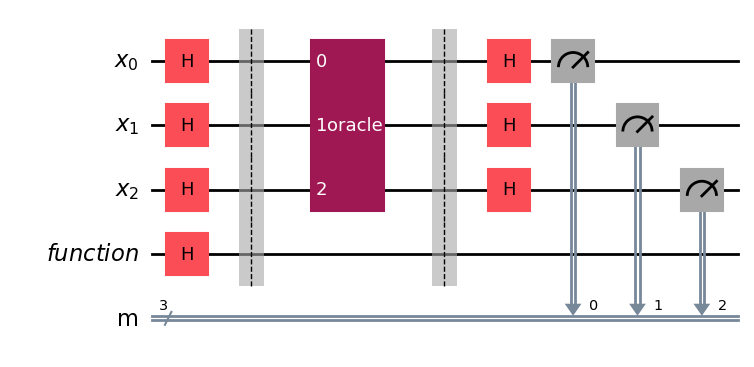

In [52]:
qc=DJA(num_qubits,func)
display(qc.draw('mpl'))

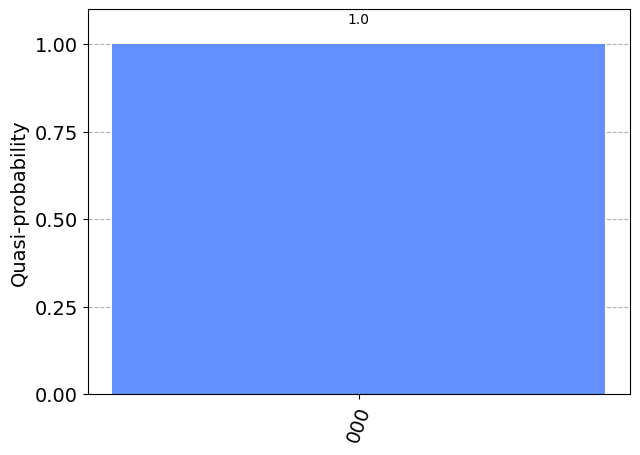

In [53]:
results = Sampler().run(qc).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

# Type-2

## Functions


In [54]:
#Constant Function
def constOracle(qubits,value):
    qc=QuantumCircuit(qubits,name='oracle')
    if not isinstance(value, int):
         raise ValueError('Value should be a integer for const function')
    if value==1:
        qc.x(qubits-1)
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(qubits)
    qc.append(qc_inst,list(range(qubits)))
    return qc

In [55]:
#Implements Balanced oracle
def balancedOracle(qubits,value):
    qc=QuantumCircuit(qubits,name='oracle')
    for i in range(qubits-1):
        if value[i]==1:
            qc.x(i)
    qc.barrier()
    for i in range(qubits-1):
        qc.cx(i,qubits-1)
    qc.barrier()
    for i in range(qubits-1):
        if value[i]==1:
            qc.x(i)
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(qubits)
    qc.append(qc_inst,list(range(qubits)))
    return qc

In [56]:
def DJA(num_qubits,fntype='const',value='0'):
    if num_qubits<=1:
        raise ValueError("num_qubits should be greater than 1")
    #QuantumRegisters
    qr=QuantumRegister(num_qubits,'x')
    qr1=QuantumRegister(1,'function')
    #ClassicalRegisters
    cr=ClassicalRegister(num_qubits,'m')
    #QuantumCircuit constucted
    qc=QuantumCircuit(qr,qr1,cr)
    #HadamardGate for every qubit
    qc.x(num_qubits)
    for i in range(num_qubits+1):
        qc.h(i)
    qc.barrier()
    if fntype=='const':
        qc.compose(constOracle(num_qubits+1,value),list(range(num_qubits+1)), inplace=True)
    else:
        qc.compose(balancedOracle(num_qubits+1,value),list(range(num_qubits+1)), inplace=True)
    qc.barrier()
    for i in range(num_qubits):
        qc.h(i) 
    for i in range(num_qubits):
        qc.measure(i,i)
    qc.draw('mpl')
    
    return qc

## Example

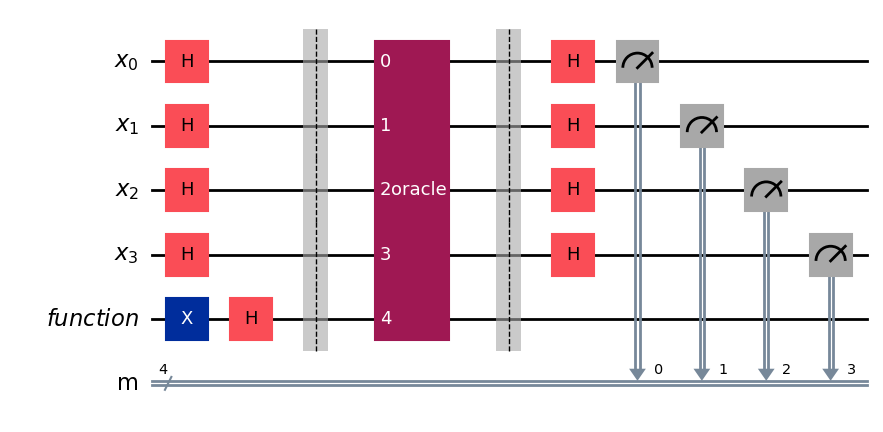

In [57]:
# First parameter: Give the number of qubits.
# Second parameter: Define the type of function. Use the 'const' string argument for a constant function.
# Third parameter: If 'const' is used as the second argument, this should be an integer. If it is equal to 1, a constant function whose output is 1 is considered. Otherwise, a constant 0 function is considered.
# If any other string argument is used for the second parameter, it implies a balanced function.
# In this case, the third argument should be a list. The 'x' operator will be applied to the qubits corresponding to the value 1 in the provided list.

qc=DJA(4,'const',1)
qc=DJA(4,'balanced',[1,1,0,0])
qc.draw('mpl')

In [ ]:
results=execute(qc,Aer.get_backend('qasm_simulator')).result()
answer = results.get_counts()
plot_histogram(answer)